In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob as glob
import random
import cv2
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

from torch.utils.data import Dataset
from torchvision import models, transforms

random.seed(0)
torch.manual_seed(0)

In [3]:
os.getcwd()

'/home/jovyan/workspace/CrackDetection/testSOTACrackClassification/models/ViTClassifier'

In [4]:
# data_dir = '../../datasets/DATA_Maguire_20180517_ALL'
data_dir = '../../../SDNET2018'
img_list = glob.glob(f'{data_dir}/**/*.jpg', recursive=True)
all_Y = [1 if 'U' not in x else 0 for x in img_list]


[0 1] [47608  8484]


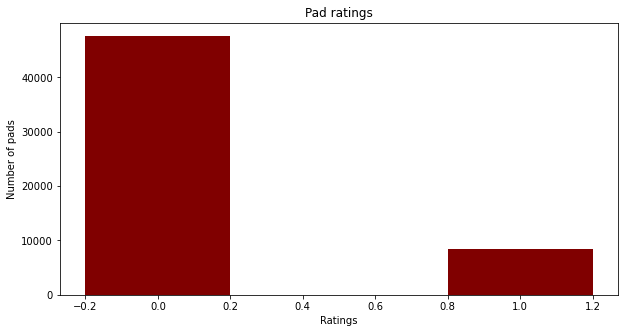

In [5]:
label_values = all_Y
values, counts = np.unique(label_values, return_counts = True)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, counts, color ='maroon',
        width = 0.4)
print(values, counts)
 
plt.xlabel("Ratings")
plt.ylabel("Number of pads")
plt.title("Pad ratings")
plt.show()
num_classes = len(values)

In [6]:
#Sample for balance dataset:
non_crack_img_list = [path for path, element in zip(img_list, all_Y) if element == 0]
non_crack_to_train = random.sample(non_crack_img_list, counts[1])
non_crack_left = [x for x in non_crack_img_list if x not in non_crack_to_train]
print(len(non_crack_to_train), len(non_crack_left))

8484 39124


In [7]:
crack_img_list = [path for path, element in zip(img_list, all_Y) if element == 1]
print(len(crack_img_list))

8484


In [8]:
X = crack_img_list+non_crack_to_train
print(len(X))
y = [1 for x in range(len(crack_img_list))] + [0 for x in range(len(non_crack_to_train))]
print(np.unique(y, return_counts=True))

16968
(array([0, 1]), array([8484, 8484]))


In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify = y_train)
print(len(X_train), len(X_val), len(X_test))

10180 3394 3394


In [10]:
#Adding the rest of the non-crack into y_test
X_test.extend(non_crack_left)
y_test.extend([0 for x in non_crack_left])

In [11]:
#create dataset from dataframe
class CrackDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = torch.tensor(self.y[idx],dtype=torch.long)
        
        img_path = self.X[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if(img.shape[:2] != (224,224)):
            img = cv2.resize(img,(224,224))
        
        img = Image.fromarray(np.uint8(img)).convert('RGB')

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

In [12]:
from sklearn.model_selection import train_test_split  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

#load data from a list of paths
image_datasets = {
'train': 
CrackDataset(X_train, y_train, transforms=data_transforms['train']),
'validation': 
CrackDataset(X_val, y_val, transforms=data_transforms['validation']),
'test': 
CrackDataset(X_test, y_test, transforms=data_transforms['validation']),
'full':
CrackDataset(X_train + X_val + X_test, y_train + y_val + y_test, transforms=data_transforms['validation']),
}

batch_size = 512
num_workers = 4
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers),
    'full':
    torch.utils.data.DataLoader(image_datasets['full'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
}



cuda:0


In [12]:
#Model define
model = models.vit_b_16(pretrained=True, progress=False).to(device)


In [13]:
for param in model.parameters():
    param.requires_grad = False   

num_classes = 2
model.heads = nn.Sequential(

               nn.Linear(model.heads.head.in_features, num_classes),

               ).to(device)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [14]:
# #Naive class weights
# from sklearn.utils import class_weight
# class_weights_array = class_weight.compute_class_weight('balanced', classes = np.unique(np.asarray(labels)), y = np.asarray(labels))
# class_weights = torch.from_numpy(class_weights_array)
# class_weights = torch.tensor(class_weights, dtype = torch.float32).to(device)
# print('class_weight_array',class_weights)

In [15]:
os.getcwd()

'/home/jovyan/workspace/CrackDetection/testSOTACrackClassification/models/ViTClassifier'

In [13]:
model_save_path = "weights"
os.makedirs(model_save_path, exist_ok = True)

In [17]:
criterion = nn.CrossEntropyLoss()#weight = class_weights)
lr=0.01
optimizer = optim.Adam(model.heads.parameters(), lr = lr)
f1_diff_threshold = 0.0005
patience = 15
num_epochs = 300
run_name = model_save_path.split('/')[-1]
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 8, verbose = True)

def train_model(model, 
                criterion, 
                optimizer, 
                num_epochs=3, 
                f1_diff_threshold = f1_diff_threshold, 
                patience = patience, 
                model_save_path = model_save_path,
                run_name = run_name,
               ):
    validation_f1s = []
    max_f1_index = 0
    num_epochs_not_improving = 0
    metrics = {
        'validation_f1s': [], 
        'validation_accs': [],
        'validation_loss': [],
        'training_f1s': [], 
        'training_accs': [], 
        'training_loss': [],
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            pred_c = np.array([])
            label_c = np.array([])

            print(phase, ':')

            for inputs, labels in tqdm(dataloaders[phase]):                
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
#                     loss = CB_loss(labels, logits, samples_per_cls, no_of_classes,loss_type, beta, gamma)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                label_c = np.concatenate((label_c, labels.data.cpu().numpy()))
                pred_c = np.concatenate((pred_c, preds.cpu().numpy()))
            f1 = f1_score(y_true = label_c, y_pred = pred_c, average = 'micro')
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = (running_corrects*1.0) / len(image_datasets[phase])


            if phase == 'validation':
                cf = confusion_matrix(label_c, pred_c)
                print(cf)

                validation_f1s.append(f1)
                metrics['validation_f1s'].append(f1)
                metrics['validation_accs'].append(float(epoch_acc))
                metrics['validation_loss'].append(epoch_loss)

                if f1 - validation_f1s[max_f1_index] > f1_diff_threshold:
                    max_f1_index = len(validation_f1s) - 1
                    num_epochs_not_improving = 0

                    # Save model
                    print(f"Saving model at epoch {epoch}")
                    torch.save(model, f'{model_save_path}/best_model_epoch{epoch}.pth')

                elif f1 - validation_f1s[max_f1_index] <= f1_diff_threshold:
                    num_epochs_not_improving += 1
                    if(num_epochs_not_improving > patience):
                        torch.save(model, f'{model_save_path}/last_model.pth')
                        print(f'Early Stopping at epoch {epoch} ')
                        return model
                
                if epoch == 0:
                    print(f"Saving model at epoch {epoch}")
                    torch.save(model, f'{model_save_path}/best_model_epoch{epoch}.pth')

            elif phase == 'train':
                metrics['training_f1s'].append(f1)
                metrics['training_accs'].append(float(epoch_acc))
                metrics['training_loss'].append(epoch_loss)
                scheduler.step(epoch_loss)

            print('{} loss: {:.4f}, acc: {:.4f}, f1: {:.4f}'.format(phase,
                                                                    epoch_loss,
                                                                    epoch_acc, 
                                                                    f1))

    torch.save(model, f'{model_save_path}/last_model.pth')
    print(f'Ran all {num_epochs} epochs')
    return model, metrics



In [18]:
model_trained, metrics = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/300
----------
train :


100%|██████████| 20/20 [02:22<00:00,  7.11s/it]


train loss: 0.5135, acc: 0.7512, f1: 0.7512
validation :


100%|██████████| 7/7 [00:50<00:00,  7.20s/it]


[[1591  106]
 [ 483 1214]]
Saving model at epoch 0
validation loss: 0.4070, acc: 0.8265, f1: 0.8265
Epoch 2/300
----------
train :


100%|██████████| 20/20 [02:30<00:00,  7.52s/it]


train loss: 0.3945, acc: 0.8253, f1: 0.8253
validation :


100%|██████████| 7/7 [00:50<00:00,  7.18s/it]


[[1442  255]
 [ 295 1402]]
Saving model at epoch 1
validation loss: 0.3559, acc: 0.8379, f1: 0.8379
Epoch 3/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.48s/it]


train loss: 0.3752, acc: 0.8307, f1: 0.8307
validation :


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


[[1456  241]
 [ 313 1384]]
validation loss: 0.3532, acc: 0.8368, f1: 0.8368
Epoch 4/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.43s/it]


train loss: 0.3610, acc: 0.8404, f1: 0.8404
validation :


100%|██████████| 7/7 [00:50<00:00,  7.23s/it]


[[1551  146]
 [ 363 1334]]
Saving model at epoch 3
validation loss: 0.3484, acc: 0.8500, f1: 0.8500
Epoch 5/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


train loss: 0.3542, acc: 0.8427, f1: 0.8427
validation :


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


[[1535  162]
 [ 340 1357]]
Saving model at epoch 4
validation loss: 0.3363, acc: 0.8521, f1: 0.8521
Epoch 6/300
----------
train :


100%|██████████| 20/20 [02:26<00:00,  7.34s/it]


train loss: 0.3495, acc: 0.8445, f1: 0.8445
validation :


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


[[1481  216]
 [ 293 1404]]
validation loss: 0.3369, acc: 0.8500, f1: 0.8500
Epoch 7/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


train loss: 0.3466, acc: 0.8472, f1: 0.8472
validation :


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


[[1581  116]
 [ 395 1302]]
validation loss: 0.3395, acc: 0.8494, f1: 0.8494
Epoch 8/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.44s/it]


train loss: 0.3450, acc: 0.8494, f1: 0.8494
validation :


100%|██████████| 7/7 [00:52<00:00,  7.43s/it]


[[1594  103]
 [ 412 1285]]
validation loss: 0.3398, acc: 0.8483, f1: 0.8483
Epoch 9/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


train loss: 0.3412, acc: 0.8490, f1: 0.8490
validation :


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


[[1591  106]
 [ 405 1292]]
validation loss: 0.3369, acc: 0.8494, f1: 0.8494
Epoch 10/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


train loss: 0.3394, acc: 0.8488, f1: 0.8488
validation :


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


[[1599   98]
 [ 419 1278]]
validation loss: 0.3438, acc: 0.8477, f1: 0.8477
Epoch 11/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.48s/it]


train loss: 0.3403, acc: 0.8493, f1: 0.8493
validation :


100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


[[1544  153]
 [ 337 1360]]
Saving model at epoch 10
validation loss: 0.3296, acc: 0.8556, f1: 0.8556
Epoch 12/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


train loss: 0.3443, acc: 0.8466, f1: 0.8466
validation :


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


[[1515  182]
 [ 313 1384]]
validation loss: 0.3312, acc: 0.8542, f1: 0.8542
Epoch 13/300
----------
train :


100%|██████████| 20/20 [02:27<00:00,  7.38s/it]


train loss: 0.3441, acc: 0.8502, f1: 0.8502
validation :


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


[[1451  246]
 [ 273 1424]]
validation loss: 0.3341, acc: 0.8471, f1: 0.8471
Epoch 14/300
----------
train :


100%|██████████| 20/20 [02:26<00:00,  7.35s/it]


train loss: 0.3381, acc: 0.8497, f1: 0.8497
validation :


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


[[1597  100]
 [ 382 1315]]
Saving model at epoch 13
validation loss: 0.3323, acc: 0.8580, f1: 0.8580
Epoch 15/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.48s/it]


train loss: 0.3383, acc: 0.8514, f1: 0.8514
validation :


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


[[1577  120]
 [ 369 1328]]
validation loss: 0.3341, acc: 0.8559, f1: 0.8559
Epoch 16/300
----------
train :


100%|██████████| 20/20 [02:31<00:00,  7.56s/it]


train loss: 0.3399, acc: 0.8503, f1: 0.8503
validation :


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


[[1555  142]
 [ 353 1344]]
validation loss: 0.3327, acc: 0.8542, f1: 0.8542
Epoch 17/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.40s/it]


train loss: 0.3373, acc: 0.8528, f1: 0.8528
validation :


100%|██████████| 7/7 [00:51<00:00,  7.37s/it]


[[1391  306]
 [ 227 1470]]
validation loss: 0.3429, acc: 0.8430, f1: 0.8430
Epoch 18/300
----------
train :


100%|██████████| 20/20 [02:32<00:00,  7.62s/it]


train loss: 0.3407, acc: 0.8458, f1: 0.8458
validation :


100%|██████████| 7/7 [00:51<00:00,  7.42s/it]


[[1521  176]
 [ 315 1382]]
validation loss: 0.3262, acc: 0.8553, f1: 0.8553
Epoch 19/300
----------
train :


100%|██████████| 20/20 [02:34<00:00,  7.72s/it]


train loss: 0.3400, acc: 0.8513, f1: 0.8513
validation :


100%|██████████| 7/7 [00:52<00:00,  7.56s/it]


[[1523  174]
 [ 315 1382]]
validation loss: 0.3273, acc: 0.8559, f1: 0.8559
Epoch 20/300
----------
train :


100%|██████████| 20/20 [02:35<00:00,  7.76s/it]


train loss: 0.3292, acc: 0.8557, f1: 0.8557
validation :


100%|██████████| 7/7 [00:52<00:00,  7.57s/it]


[[1489  208]
 [ 291 1406]]
validation loss: 0.3307, acc: 0.8530, f1: 0.8530
Epoch 21/300
----------
train :


100%|██████████| 20/20 [02:34<00:00,  7.74s/it]


train loss: 0.3312, acc: 0.8540, f1: 0.8540
validation :


100%|██████████| 7/7 [00:52<00:00,  7.57s/it]


[[1592  105]
 [ 396 1301]]
validation loss: 0.3364, acc: 0.8524, f1: 0.8524
Epoch 22/300
----------
train :


100%|██████████| 20/20 [02:31<00:00,  7.56s/it]


train loss: 0.3325, acc: 0.8531, f1: 0.8531
validation :


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


[[1454  243]
 [ 275 1422]]
validation loss: 0.3331, acc: 0.8474, f1: 0.8474
Epoch 23/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.45s/it]


train loss: 0.3390, acc: 0.8497, f1: 0.8497
validation :


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


[[1576  121]
 [ 369 1328]]
validation loss: 0.3313, acc: 0.8556, f1: 0.8556
Epoch 24/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


train loss: 0.3307, acc: 0.8537, f1: 0.8537
validation :


100%|██████████| 7/7 [00:50<00:00,  7.15s/it]


[[1567  130]
 [ 359 1338]]
validation loss: 0.3273, acc: 0.8559, f1: 0.8559
Epoch 25/300
----------
train :


100%|██████████| 20/20 [02:27<00:00,  7.38s/it]


train loss: 0.3274, acc: 0.8577, f1: 0.8577
validation :


100%|██████████| 7/7 [00:50<00:00,  7.15s/it]


[[1517  180]
 [ 312 1385]]
validation loss: 0.3264, acc: 0.8550, f1: 0.8550
Epoch 26/300
----------
train :


100%|██████████| 20/20 [02:27<00:00,  7.40s/it]


train loss: 0.3362, acc: 0.8512, f1: 0.8512
validation :


100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


[[1544  153]
 [ 332 1365]]
validation loss: 0.3269, acc: 0.8571, f1: 0.8571
Epoch 27/300
----------
train :


100%|██████████| 20/20 [02:27<00:00,  7.39s/it]


train loss: 0.3437, acc: 0.8458, f1: 0.8458
validation :


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


[[1543  154]
 [ 334 1363]]
validation loss: 0.3260, acc: 0.8562, f1: 0.8562
Epoch 28/300
----------
train :


100%|██████████| 20/20 [02:27<00:00,  7.40s/it]


train loss: 0.3347, acc: 0.8538, f1: 0.8538
validation :


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


[[1472  225]
 [ 282 1415]]
validation loss: 0.3315, acc: 0.8506, f1: 0.8506
Epoch 29/300
----------
train :


100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


train loss: 0.3317, acc: 0.8536, f1: 0.8536
validation :


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


[[1452  245]
 [ 252 1445]]
validation loss: 0.3307, acc: 0.8536, f1: 0.8536
Epoch 30/300
----------
train :


100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


train loss: 0.3290, acc: 0.8525, f1: 0.8525
validation :


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


[[1593  104]
 [ 404 1293]]
Early Stopping at epoch 29 


TypeError: cannot unpack non-iterable VisionTransformer object

In [19]:
for value in ['loss', 'f1s', 'accs']:
    training_value = metrics[f'training_{value}']
    validation_value = metrics[f'validation_{value}']
    save_path = f'evaluation/{value}_graph.png'
    os.makedirs(os.path.dirname(save_path), exist_ok = True)
    fig = plt.figure(figsize = (10,5))
    plt.title(save_path)
    plt.plot(training_value, '.')
    plt.plot(validation_value, '.')
    plt.show()
    fig.savefig(save_path, facecolor = 'white')

NameError: name 'metrics' is not defined

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues, save_path = None):
    #cm output from sklearn.confusion_matrix
    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j], 2),
                          ha="center", va="center", color="k")
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_path == None:
        plt.show()
    else:
        plt.savefig(save_path, facecolor = 'white')

def iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
def evaluate(y_truth, y_pred, labels, 
        save_confusion_matrix_path = 'evaluation_results/sample.png', 
        save_classification_report_path = 'evaluation_results/sample.csv'
        ): 
    labels = [str(x) for x in labels]

    print('Classification Report')
    cls_report = classification_report(y_truth, y_pred,labels = [x for x in range(len(labels))], target_names=labels)
    if save_classification_report_path != None:
        df = pd.DataFrame(cls_report).transpose()
        df.to_csv(save_classification_report_path)
    print(cls_report)

    print('Confusion Matrix')
    plot_confusion_matrix(confusion_matrix(y_truth, y_pred, normalize = 'true'), labels = labels, save_path = save_confusion_matrix_path)


EVALUATE The last model (epoch 300)

In [15]:
#Evaluation model with 200 epochs on both train and val dataset
model_trained = torch.load(f'{model_save_path}/last_model.pth')
model_trained.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


cuda:0


100%|██████████| 20/20 [02:27<00:00,  7.39s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      5090
           1       0.93      0.77      0.84      5090

    accuracy                           0.85     10180
   macro avg       0.86      0.85      0.85     10180
weighted avg       0.86      0.85      0.85     10180

Confusion Matrix


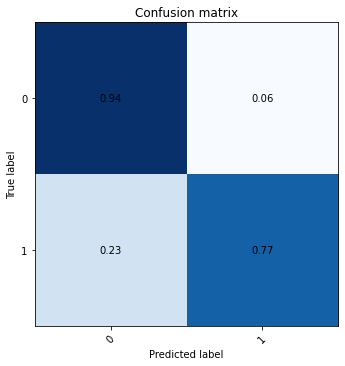

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Inference
model_trained.eval().to(device)
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/train_last_model.png', 
        save_classification_report_path = None,
        )

100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1697
           1       0.93      0.76      0.84      1697

    accuracy                           0.85      3394
   macro avg       0.86      0.85      0.85      3394
weighted avg       0.86      0.85      0.85      3394

Confusion Matrix


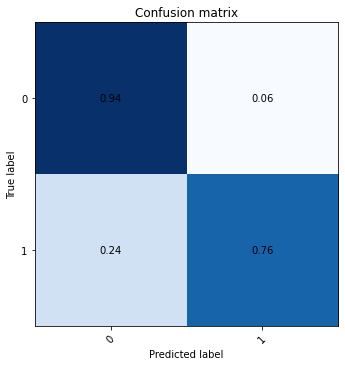

In [24]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['validation']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/val_last_model.png', 
        save_classification_report_path = None,
        )

100%|██████████| 84/84 [08:49<00:00,  6.30s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     40821
           1       0.31      0.76      0.44      1697

    accuracy                           0.92     42518
   macro avg       0.65      0.84      0.70     42518
weighted avg       0.96      0.92      0.94     42518

Confusion Matrix


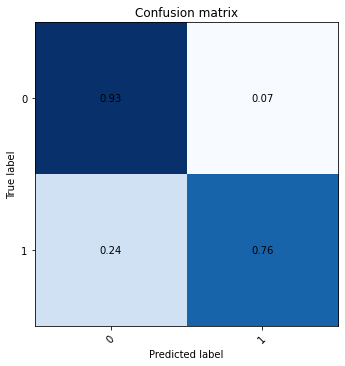

In [17]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/test_last_model.png', 
        save_classification_report_path = None,
        )

EVALUATE The Best F1 model

cuda:0


100%|██████████| 20/20 [02:01<00:00,  6.10s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      5090
           1       0.91      0.78      0.84      5090

    accuracy                           0.85     10180
   macro avg       0.86      0.85      0.85     10180
weighted avg       0.86      0.85      0.85     10180

Confusion Matrix


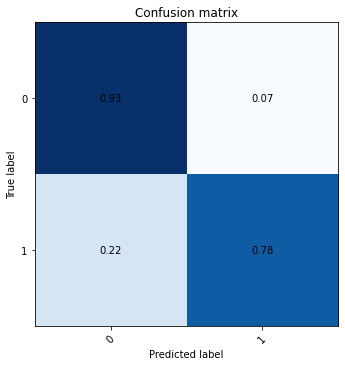

In [18]:
#Eval best model
model_trained = torch.load(f'{model_save_path}/best_model_epoch13.pth')
model_trained.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Inference
model_trained.eval().to(device)
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/train_best_model.png', 
        save_classification_report_path = None,
        )

100%|██████████| 7/7 [00:42<00:00,  6.06s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1697
           1       0.93      0.77      0.85      1697

    accuracy                           0.86      3394
   macro avg       0.87      0.86      0.86      3394
weighted avg       0.87      0.86      0.86      3394

Confusion Matrix


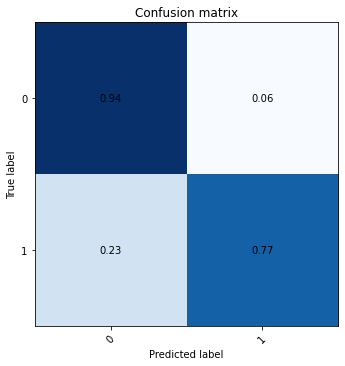

In [19]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['validation']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/val_best_model.png', 
        save_classification_report_path = None,
        )

100%|██████████| 84/84 [08:36<00:00,  6.14s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     40821
           1       0.30      0.76      0.43      1697

    accuracy                           0.92     42518
   macro avg       0.64      0.84      0.69     42518
weighted avg       0.96      0.92      0.93     42518

Confusion Matrix


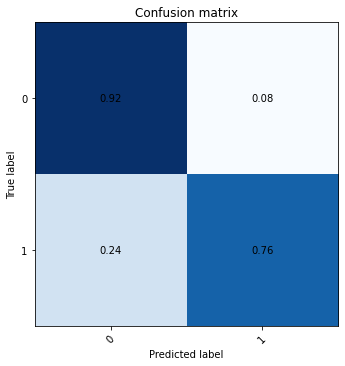

In [20]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/test_best_model.png', 
        save_classification_report_path = None,
        )

100%|██████████| 110/110 [11:07<00:00,  6.07s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     47608
           1       0.65      0.78      0.71      8484

    accuracy                           0.90     56092
   macro avg       0.80      0.85      0.82     56092
weighted avg       0.91      0.90      0.91     56092

Confusion Matrix


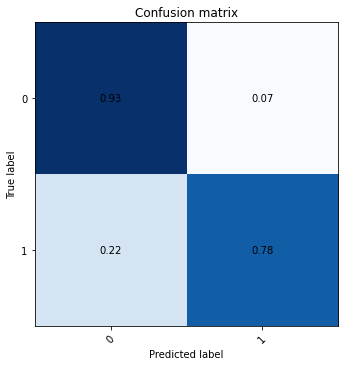

In [21]:
#Eval best model
# all_models = glob.glob(f'{model_save_path}/best_model_epoch*')

# model_trained = torch.load(all_models[0])
# model_trained.eval()

pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['full']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/fullSDNet_best_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
# del model_trained
# torch.cuda.empty_cache()

In [ ]:
print(1)